<a href="https://colab.research.google.com/github/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting/blob/main/notebooks/unnamed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting.git

%cd Walmart-Recruiting-Store-Sales-Forecasting

from google.colab import userdata
! pip install -r ./requirements.txt
kaggle_json_path = userdata.get('KAGGLE_JSON_PATH')
! ./src/data_loader.sh -f {kaggle_json_path}

# **Read Data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MSE

from src.config import *

stores = pd.read_csv(STORES_PATH)
features = pd.read_csv(FEATURES_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

from src import data_loader, processing
import importlib
importlib.reload(processing)

dataframes = data_loader.load_raw_data()
df = processing.run_preprocessing(dataframes, process_test=False, merge_features=False, merge_stores=False)['train']
X_train, y_train, X_valid, y_valid = processing.split_data_by_ratio(df, separate_target=True)

print(f"Shapes of train_df and valid_df: {X_train.shape}, {X_valid.shape}")

Data loading complete.
Shapes of train_df and valid_df: (337256, 4), (84314, 4)


# **NBEATS**

In [ ]:
from neuralforecast.models import NBEATS
from models.neural_forecast_models import NeuralForecastModels
from src.utils import wmae as compute_wmae
import logging

logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("neuralforecast").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning_fabric").setLevel(logging.WARNING)

model = NBEATS(
    max_steps= 25 * 104,
    h= 53,
    random_seed= 42,
    input_size=52,
    batch_size= 256,
    learning_rate= 1e-3,
    shared_weights=True,
    optimizer= torch.optim.AdamW,
    activation = 'ReLU',
    enable_progress_bar = False
)
nbeats_model = NeuralForecastModels(models=[model], model_names=['NBEATS'], freq='W-FRI', one_model=True)

nbeats_model.fit(X_train, y_train)
nbeats_pred = nbeats_model.predict(X_valid)
wmae = compute_wmae(y_valid, nbeats_pred, X_valid['IsHoliday'])

print(wmae)

1587.5858753093955


# **DLinear**

In [ ]:

from neuralforecast.models import DLinear
from models.neural_forecast_models import NeuralForecastModels
from src.utils import wmae as compute_wmae


model = DLinear(
    max_steps= 25 * 104,
    h= 53,
    random_seed= 42,
    input_size=60,
    batch_size= 512,
    learning_rate= 1e-2,
    optimizer= torch.optim.Adagrad,
    scaler_type= 'robust',
    enable_progress_bar=False,
    enable_model_summary=False
)
dlinear_model = NeuralForecastModels(models=[model], model_names=['DLinear'], freq='W-FRI', one_model=True)

dlinear_model.fit(X_train, y_train)
dlinear_pred = dlinear_model.predict(X_valid)
wmae = compute_wmae(y_valid, dlinear_pred, X_valid['IsHoliday'])

print(wmae)

1592.9378746510185


# **PatchTST**

In [ ]:
from neuralforecast.models import PatchTST
from models.neural_forecast_models import NeuralForecastModels
from src.utils import wmae as compute_wmae

model = PatchTST(
    input_size=52,
    dropout = 0.2,
    h=53,
    max_steps= 60 * 104,
    batch_size=64,
    random_seed=42,
    activation='relu',
    enable_progress_bar=False,
    enable_model_summary=False,
)
patchtst_model = NeuralForecastModels(models=[model], model_names=['PatchTST'], freq='W-FRI', one_model=True)

patchtst_model.fit(X_train, y_train)
patchtst_pred = patchtst_model.predict(X_valid)
wmae = compute_wmae(y_valid, patchtst_pred, X_valid['IsHoliday'])

print(wmae)

1526.4649587770039


# **TFT**

In [ ]:
from neuralforecast.models import TFT
from models.neural_forecast_models import NeuralForecastModels
from src.utils import wmae as compute_wmae

model = TFT(
    input_size=60,
    dropout = 0.1,
    h=53,
    max_steps= 20 * 104,
    random_seed=42,
    enable_progress_bar=False,
    enable_model_summary=False,
)
tft_model = NeuralForecastModels(models=[model], model_names=['TFT'], freq='W-FRI', one_model=True)
tft_model.fit(X_train, y_train)
tft_pred = tft_model.predict(X_valid)
wmae = compute_wmae(y_valid, tft_pred, X_valid['IsHoliday'])

print(wmae)

1717.1530206837165


In [ ]:
nbeats_pred

,NBEATS
0,5774.666016
1,7809.554688
2,23903.486328
3,5972.651855
4,2158.010742
...,...
84309,1595.276855
84310,3905.636475
84311,52225.414062
84312,5837.969727


In [ ]:
nbeats_pred_r = nbeats_pred.reset_index()
dlinear_pred_r = dlinear_pred.reset_index()
patchtst_pred_r = patchtst_pred.reset_index()
tft_pred_r = tft_pred.reset_index()
y_val_r = y_valid.reset_index()
x_val_r = X_valid.reset_index()
# dlinear_pred_r
x_val_r['nbeats_pred'] = nbeats_pred_r['NBEATS']
x_val_r['dlinear_pred'] = dlinear_pred_r['DLinear']
x_val_r['patchtst_pred'] = patchtst_pred_r['PatchTST']
x_val_r['tft_pred'] = tft_pred_r['TFT']
x_val_r['Weekly_Sales'] = y_val_r['Weekly_Sales']
x_val_r['avarage'] = (x_val_r['nbeats_pred'] + x_val_r['dlinear_pred'] + x_val_r['patchtst_pred'] + x_val_r['tft_pred'])/4

In [ ]:
x_val_r

,index,Store,Dept,Date,IsHoliday,nbeats_pred,dlinear_pred,patchtst_pred,tft_pred,Weekly_Sales,avarage
0,337256,22,32,2012-04-13,False,5774.666016,5591.454590,5663.810547,5936.138672,6236.25,5741.517578
1,337257,22,33,2012-04-13,False,7809.554688,7885.141602,7899.987305,8396.578125,6179.73,7997.815430
2,337258,22,34,2012-04-13,False,23903.486328,24280.769531,22622.742188,26013.666016,24139.31,24205.166016
3,337259,22,35,2012-04-13,False,5972.651855,5656.695312,5524.515625,6694.514648,4432.28,5962.094727
4,337260,22,36,2012-04-13,False,2158.010742,2526.148438,2384.264160,2551.418701,2256.69,2404.960449
...,...,...,...,...,...,...,...,...,...,...,...
84309,421565,45,93,2012-10-26,False,1595.276855,1780.600220,1801.274902,2205.812744,2487.80,1845.741211
84310,421566,45,94,2012-10-26,False,3905.636475,3849.432861,3900.392578,3408.061523,5203.31,3765.880859
84311,421567,45,95,2012-10-26,False,52225.414062,50962.078125,51689.984375,51954.816406,56017.47,51708.070312
84312,421568,45,97,2012-10-26,False,5837.969727,5700.243652,5822.276367,6220.403320,6817.48,5895.222656


In [ ]:
print(compute_wmae(x_val_r['Weekly_Sales'], x_val_r['nbeats_pred'], x_val_r['IsHoliday']))
print(compute_wmae(x_val_r['Weekly_Sales'], x_val_r['dlinear_pred'], x_val_r['IsHoliday']))
print(compute_wmae(x_val_r['Weekly_Sales'], x_val_r['patchtst_pred'], x_val_r['IsHoliday']))
print(compute_wmae(x_val_r['Weekly_Sales'], x_val_r['tft_pred'], x_val_r['IsHoliday']))
print(compute_wmae(x_val_r['Weekly_Sales'], x_val_r['avarage'], x_val_r['IsHoliday']))

1587.5858753093955
1592.9378746510185
1526.4649587770039
1717.1530206837165
1467.9026209686613


In [ ]:
dept1 = x_val_r[(x_val_r['Dept'] == 1) & (x_val_r['Store'] == 1)]
dept1

,index,Store,Dept,Date,IsHoliday,nbeats_pred,dlinear_pred,patchtst_pred,tft_pred,Weekly_Sales,avarage
1482,338738,1,1,2012-04-20,False,54804.710938,46910.578125,42517.312500,32899.738281,16976.19,44283.082031
4457,341713,1,1,2012-04-27,False,48434.113281,41693.335938,38852.531250,29743.234375,16347.60,39680.804688
7411,344667,1,1,2012-05-04,False,24399.027344,30252.910156,23220.308594,25402.894531,17147.44,25818.785156
10366,347622,1,1,2012-05-11,False,14177.347656,25078.044922,18193.837891,22447.943359,18164.20,19974.292969
13339,350595,1,1,2012-05-18,False,14730.207031,24209.515625,15311.517578,21560.996094,18517.79,18953.058594
16292,353548,1,1,2012-05-25,False,13518.960938,23246.578125,15011.636719,21227.478516,16963.55,18251.164062
19233,356489,1,1,2012-06-01,False,15128.082031,23267.339844,15312.193359,21109.929688,16065.49,18704.386719
22176,359432,1,1,2012-06-08,False,16121.212891,22963.603516,16505.695312,21142.814453,17666.00,19183.332031
25136,362392,1,1,2012-06-15,False,14351.179688,22860.416016,18115.376953,21234.537109,17558.82,19140.376953
28092,365348,1,1,2012-06-22,False,15280.939453,22606.457031,17226.068359,21330.324219,16633.41,19110.949219


# **Plot predictions**

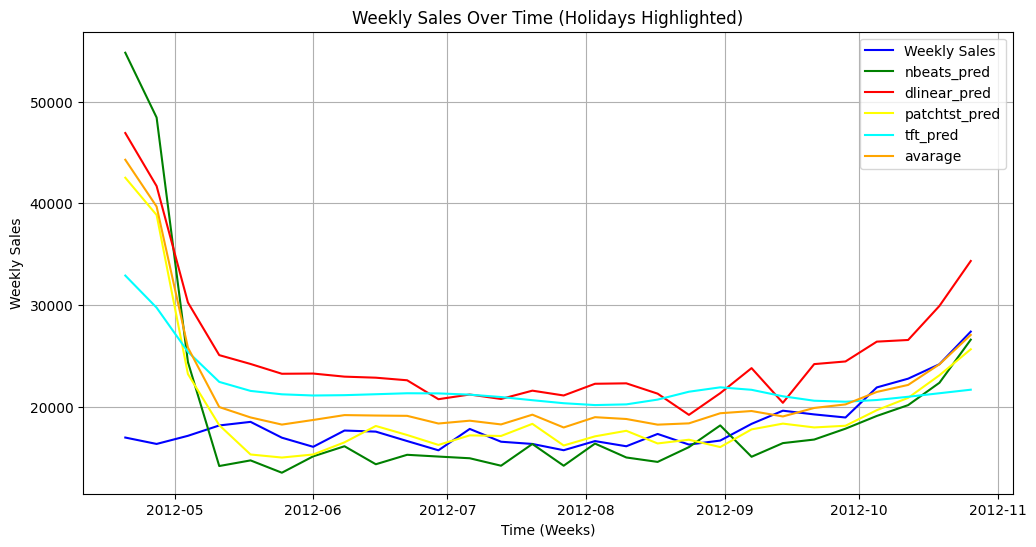

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dept1['Date'], dept1['Weekly_Sales'], label='Weekly Sales', color='blue')

plt.plot(dept1['Date'], dept1['nbeats_pred'], label='nbeats_pred', color='green')
plt.plot(dept1['Date'], dept1['dlinear_pred'], label='dlinear_pred', color='red')
plt.plot(dept1['Date'], dept1['patchtst_pred'], label='patchtst_pred', color='yellow')
plt.plot(dept1['Date'], dept1['tft_pred'], label='tft_pred', color='cyan')
plt.plot(dept1['Date'], dept1['avarage'], label='avarage', color='orange')

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

# **Create assemble Pipeline**

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
class NNAssemble(BaseEstimator,RegressorMixin):
  def __init__(self, models):
    self.models = models

  def fit(self, X, y):
    for model in self.models:
      model.fit(X, y)

    return self

  def predict(self, X):
    predictions = [model.predict(X) for model in self.models]
    return np.mean(predictions, axis=0)

In [4]:
from neuralforecast.models import NBEATS
from neuralforecast.models import DLinear
from neuralforecast.models import PatchTST
from neuralforecast.models import TFT
from models.neural_forecast_models import NeuralForecastModels
from src.utils import wmae as compute_wmae
import logging

logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("neuralforecast").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning_fabric").setLevel(logging.WARNING)

model = NBEATS(
    max_steps= 25 * 104,
    h= 53,
    random_seed= 42,
    input_size=52,
    batch_size= 256,
    learning_rate= 1e-3,
    shared_weights=True,
    optimizer= torch.optim.AdamW,
    activation = 'ReLU',
    enable_progress_bar = False
)
nbeats_model = NeuralForecastModels(models=[model], model_names=['NBEATS'], freq='W-FRI', one_model=True)


model = DLinear(
    max_steps= 25 * 104,
    h= 53,
    random_seed= 42,
    input_size=60,
    batch_size= 512,
    learning_rate= 1e-2,
    optimizer= torch.optim.Adagrad,
    scaler_type= 'robust',
    enable_progress_bar=False,
    enable_model_summary=False
)
dlinear_model = NeuralForecastModels(models=[model], model_names=['DLinear'], freq='W-FRI', one_model=True)


model = PatchTST(
    input_size=52,
    dropout = 0.2,
    h=53,
    max_steps= 60 * 104,
    batch_size=64,
    random_seed=42,
    activation='relu',
    enable_progress_bar=False,
    enable_model_summary=False,
)
patchtst_model = NeuralForecastModels(models=[model], model_names=['PatchTST'], freq='W-FRI', one_model=True)

model = TFT(
    input_size=60,
    dropout = 0.1,
    h=53,
    max_steps= 20 * 104,
    random_seed=42,
    enable_progress_bar=False,
    enable_model_summary=False,
)
tft_model = NeuralForecastModels(models=[model], model_names=['TFT'], freq='W-FRI', one_model=True)

In [7]:
amodel = NNAssemble([nbeats_model,patchtst_model,tft_model,dlinear_model]).fit(X_train,y_train)

In [8]:
predicted = amodel.predict(X_valid)

In [11]:
from src.utils import wmae as compute_wmae
print(compute_wmae(y_valid, predicted, X_valid['IsHoliday']))

1467.9026245365594


# **Train on Entire dataset**

In [12]:
amodel = NNAssemble([nbeats_model,patchtst_model,tft_model,dlinear_model]).fit(df.drop(columns='Weekly_Sales'), df['Weekly_Sales'])

# upload to wandb

In [23]:
! wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (MLBeasts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [27]:
import wandb
import joblib

joblib.dump(amodel, "assemble_run1.pkl")
wandb.init(project="Walmart Recruiting - Store Sales Forecasting", name="assemble:run1")

wandb.config.update({
    'score_metric' : 'WMAE',
    'score_policy' : {
        'weight on holidays' : 5,
        'weight on non_holidays' : 1
    },
    'models': ['nbeats','dlinear','patchtst','tft'],
    'params' : 'see prev uploaded runs on each model'
})

wandb.log({
    'val_wmae': 1467.9026245365594
})


artifact = wandb.Artifact(
    name="assemble_run1",
    type="model",
)

artifact.add_file("assemble_run1.pkl")
wandb.log_artifact(artifact)

wandb.finish()

val_wmae,▁
val_wmae,1467.90262


In [15]:
test.Date = pd.to_datetime(test.Date)
predicted_test = amodel.predict(test)

In [22]:
out = pd.DataFrame()
out['Id'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str) + '_' + test['Date'].astype(str)
out['Weekly_Sales'] = predicted_test
out.to_csv('submission.csv', index=False)

In [21]:
out

,Id,Weekly_Sales
0,1_1_2012-11-02,28919.812500
1,1_1_2012-11-09,22636.927734
2,1_1_2012-11-16,22378.935547
3,1_1_2012-11-23,23036.859375
4,1_1_2012-11-30,25526.119141
...,...,...
115059,45_98_2013-06-28,675.731812
115060,45_98_2013-07-05,671.868530
115061,45_98_2013-07-12,679.404297
115062,45_98_2013-07-19,723.103271
